In [1]:
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, SeparableConv2D, Conv2D, Conv2DTranspose, Add,
                                     Activation, BatchNormalization, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
import pandas as pd
from skimage.metrics import structural_similarity as ssim

2025-04-29 22:16:11.018294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 22:16:11.032790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745954171.048530 3917413 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745954171.053463 3917413 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 22:16:11.070158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

I0000 00:00:1745954174.385117 3917413 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


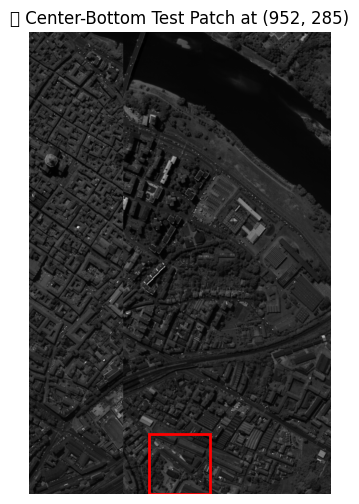

In [2]:

# -----------------------------
# Reproducibility
# -----------------------------
seed_value = 65
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# -----------------------------
# Load Pavia Dataset
# -----------------------------
data = loadmat("Pavia.mat")
if 'pavia' not in data:
    raise KeyError("'pavia' not found in the .mat file.")
hyperspectral_image = data['pavia'].astype(np.float32)

# -----------------------------
# Parameters
# -----------------------------
patch_size = (144, 144)
downscale_factor = 4
nodata_value = -1
group_size = 32
overlap_size = 8
validation_ratio = 0.1

# -----------------------------
# Compute center-bottom test patch manually
# -----------------------------
H, W, _ = hyperspectral_image.shape
patch_h, patch_w = patch_size
test_i = H - patch_h
test_j = (W - patch_w) // 2
test_coords = (test_i, test_j)

# Extract test patch
test_hr_full = hyperspectral_image[test_i:test_i + patch_h, test_j:test_j + patch_w, :]
test_lr_full = tf.image.resize(test_hr_full,
                               size=(patch_h // downscale_factor, patch_w // downscale_factor),
                               method='area').numpy()
test_hr_full = test_hr_full[np.newaxis, ...]
test_lr_full = test_lr_full[np.newaxis, ...]

# -----------------------------
# Visualize test patch
# -----------------------------
plt.figure(figsize=(6, 6))
plt.imshow(np.mean(hyperspectral_image, axis=-1), cmap='gray')
plt.gca().add_patch(plt.Rectangle((test_j, test_i), patch_w, patch_h,
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.title(f"📍 Center-Bottom Test Patch at {test_coords}")
plt.axis('off')
plt.show()

# -----------------------------
# Extract training patches (skip test region)
# -----------------------------
def extract_training_patches(data, patch_size, downscale_factor, nodata_value, test_coords):
    h, w, b = data.shape
    i_test, j_test = test_coords
    patch_h, patch_w = patch_size
    train_hr, train_lr = [], []

    for i in range(0, h - patch_h + 1, patch_h):
        for j in range(0, w - patch_w + 1, patch_w):
            if i == i_test and j == j_test:
                continue  # avoid test patch
            patch = data[i:i + patch_h, j:j + patch_w, :]
            if patch.shape[:2] != patch_size or np.any(patch == nodata_value):
                continue
            patch_lr = tf.image.resize(patch,
                                       size=(patch_h // downscale_factor, patch_w // downscale_factor),
                                       method='area').numpy()
            train_hr.append(patch)
            train_lr.append(patch_lr)
    return np.array(train_hr), np.array(train_lr)

train_hr_full, train_lr_full = extract_training_patches(
    hyperspectral_image, patch_size, downscale_factor, nodata_value, test_coords
)

# -----------------------------
# Band grouping AFTER split
# -----------------------------
def apply_band_grouping(patches, group_size, overlap_size):
    grouped = []
    for patch in patches:
        h, w, bands = patch.shape
        step = group_size - overlap_size
        for g in range(0, bands - group_size + 1, step):
            grouped_patch = patch[:, :, g:g + group_size]
            grouped.append(grouped_patch)
    return np.array(grouped)

X_train_hr = apply_band_grouping(train_hr_full, group_size, overlap_size)
X_train_lr = apply_band_grouping(train_lr_full, group_size, overlap_size)
X_test_hr = apply_band_grouping(test_hr_full, group_size, overlap_size)
X_test_lr = apply_band_grouping(test_lr_full, group_size, overlap_size)

# -----------------------------
# Validation Split
# -----------------------------
num_train = X_train_hr.shape[0]
val_size = max(1, int(validation_ratio * num_train))
indices = np.arange(num_train)
np.random.shuffle(indices)
X_train_hr = X_train_hr[indices]
X_train_lr = X_train_lr[indices]
X_validation_hr = X_train_hr[:val_size]
X_validation_lr = X_train_lr[:val_size]
X_train_hr = X_train_hr[val_size:]
X_train_lr = X_train_lr[val_size:]

In [3]:

# -----------------------------
# Residual Block (Depthwise Separable)
# -----------------------------
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# -----------------------------
# Dilated Fusion Block
# -----------------------------
def dilated_fusion_block(x, filters):
    d1 = Conv2D(filters, 1, padding='same', dilation_rate=1, activation='relu')(x)
    d2 = Conv2D(filters, 1, padding='same', dilation_rate=2, activation='relu')(x)
    d3 = Conv2D(filters, 1, padding='same', dilation_rate=3, activation='relu')(x)
    fused = Concatenate()([d1, d2, d3])
    fused = Conv2D(filters, 1, padding='same', activation='relu')(fused)
    return fused

# -----------------------------
# Upsample Block (Modular)
# -----------------------------
def upsample_block(x, filters, scale=2, use_residual=False, use_depthwise=True, use_transpose=False):
    shortcut = x  # for optional residual connection

    if use_transpose:
        x = Conv2DTranspose(filters, kernel_size=4, strides=scale, padding='same', activation='relu')(x)
    else:
        x = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
        if use_depthwise:
            x = SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
        else:
            x = Conv2D(filters, 3, padding='same', activation='relu')(x)

    if use_residual:
        if shortcut.shape[-1] != filters or shortcut.shape[1] != x.shape[1] or shortcut.shape[2] != x.shape[2]:
            shortcut = Conv2D(filters, 1, padding='same')(UpSampling2D(size=(scale, scale))(shortcut))
        x = Add()([x, shortcut])

    return x

# -----------------------------
# Spectral Angle Mapper (SAM) Loss
# -----------------------------
def spectral_angle_loss(y_true, y_pred):
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    dot_product = tf.reduce_sum(y_true * y_pred, axis=-1)
    angle = tf.acos(tf.clip_by_value(dot_product, -1.0, 1.0))
    return tf.reduce_mean(angle)

# -----------------------------
# L2 Loss (Squared Error Sum)
# -----------------------------
def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# -----------------------------
# Combined Loss: MSE + λ₁ × SAM + λ₂ × L2
# -----------------------------
def combined_loss(lambda_sam=0.1, lambda_l2=0.1):
    mse = MeanSquaredError()
    def loss_fn(y_true, y_pred):
        return mse(y_true, y_pred) + lambda_sam * spectral_angle_loss(y_true, y_pred) + lambda_l2 * l2_loss(y_true, y_pred)
    return loss_fn

# -----------------------------
# Super-Resolution Model with Modular Upsampling
# -----------------------------
def build_simple_sr_model(input_shape,
                          use_transpose=True,
                          use_depthwise=True,
                          use_residual=True):
    inputs = Input(shape=input_shape)

    # Initial feature extraction
    x = SeparableConv2D(64, 3, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, 64)

    # Dilated Fusion Block
    x = dilated_fusion_block(x, 64)

    # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=200, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)
    # Upsample x2 → x4 → x8
    x = upsample_block(x, filters=200, scale=2,
                       use_residual=use_residual,
                       use_depthwise=use_depthwise,
                       use_transpose=use_transpose)
    # Final spectral reconstruction
    output = SeparableConv2D(input_shape[-1], 3, padding='same', activation='linear')(x)

    model = Model(inputs, output, name='HSI_SR_Modular_Upsample_Model')
    return model

# -----------------------------
# Model Compilation
# -----------------------------
input_shape = (36, 36, 32)  # Low-resolution input shape (e.g. 1/8 of 144x144)
model = build_simple_sr_model(
    input_shape=input_shape,
    use_transpose=True,         # Toggle between bilinear or transposed
    use_depthwise=True,
    use_residual=True
)

model.compile(
    optimizer='adam',
    loss=combined_loss(lambda_sam=0.5, lambda_l2=0.03),
    metrics=['mse']
)
total_params = model.count_params()
size_in_bytes = total_params * 4  # 4 bytes per float32 param
size_in_mb = size_in_bytes / (1024 ** 2)
print(f"💾 Model size: {size_in_mb:.2f} MB")

#model.summary()

total_params = model.count_params()
params_in_millions = total_params / 1e6
print(f"\n🧠 Total Parameters: {params_in_millions:.2f} Million")
#30,32,  4,99
#Average PSNR on the test set: 30.44809351269405
#Average SSIM on the test set: 0.79255395
#Average SAM on the test set (in degrees): 4,2914740693309

💾 Model size: 3.68 MB

🧠 Total Parameters: 0.96 Million


Epoch 1/1000


I0000 00:00:1745954181.980816 3917463 service.cc:148] XLA service 0x7fa054013c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745954181.980841 3917463 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-04-29 22:16:22.112512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745954182.660467 3917463 cuda_dnn.cc:529] Loaded cuDNN version 90501


 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1621852.0000 - mse: 1574612.7500

I0000 00:00:1745954186.167897 3917463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1163349.2500 - mse: 1129464.8750 - val_loss: 368347.1250 - val_mse: 357618.3750
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 284871.9375 - mse: 276574.5938 - val_loss: 251387.3438 - val_mse: 244065.2969
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 190097.2344 - mse: 184560.3125 - val_loss: 193297.6875 - val_mse: 187667.5625
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 149825.2812 - mse: 145461.3438 - val_loss: 172405.5781 - val_mse: 167383.9688
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 134765.8125 - mse: 130840.5000 - val_loss: 157307.6250 - val_mse: 152725.7500
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 121826.5000 - mse: 118278.0625 - val_loss: 142032.4062 - val_mse: 137895.4531
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 109340.7891 - mse: 106156.0156 - val_loss: 132069.3594 - val_mse: 128222.6016
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━

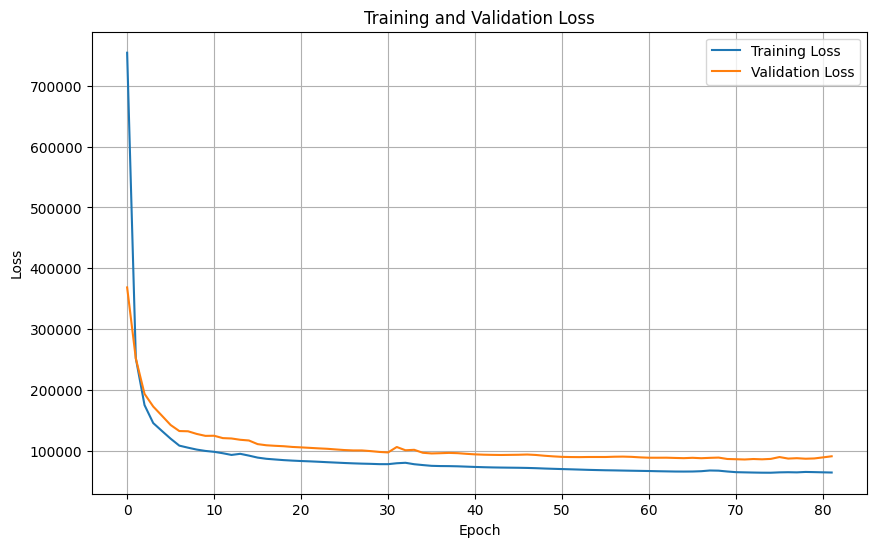

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

In [5]:
def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val


# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  model.predict(X_test_lr)

downscale_factor = 4 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-04-29 22:17:29.870813: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
Average PSNR on the test set: 29.66560701529185
Average SSIM on the test set: 0.8152576
Average SAM on the test set (in degrees): 4.826791024097795
Average Correlation Coefficient on the test set: 0.9165964426142019
Average ERGAS on the test set: 6.256679828334414
Average RMSE: 0.03321481
